In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import scipy.stats as stats
import time
from tqdm.notebook import tqdm
import scipy

## Bandits data generating function

In [2]:
def getArmsRewards(R, T, M):


    #
    # Experiment parameters
    #
    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed)
    # Trial repetitions (number of times experiment is repeated)
#     R = 2
#     # Trial size (total number of arm pulls)
#     T = 100
    # Number of arms
    K = 2
    # Noise distribution: 2*beta(alph, alph) - 1
    noise_param = 1.0 # uniform distribution
    # Parameters of Gaussian distribution prior on each arm
    mu0 = 0.4 # prior mean
    var0 = 1/(2*noise_param + 1.0) # prior variance set to correct value
    # Select reward means for each arm and set variance
    reward_means = np.concatenate([np.repeat(.3, K-1), [.30]])
    reward_vars = np.repeat(var0, K)
    # Select probability of choosing current belief in epsilon greedy policy
    ECB_epsilon = .1


    #
    # Evaluation parameters
    #
    # Confidence levels for confidence regions
    confidence_levels = np.arange(0.9, 1.0, step=0.01)
    # Standard normal error thresholds for two-sided (univariate) intervals with given confidence level
    gaussian_thresholds_ts = -stats.norm.ppf((1.0-confidence_levels)/2.0)
    gaussian_thresholds_os = -stats.norm.ppf(1.0-confidence_levels)



    #
    # Define arm selection policies
    #
    policies = {}
    # Epsilon-greedy: select current belief (arm with highest posterior reward 
    # probability) w.p. 1-epsilon and arm uniformly at random otherwise
    def ECB(mu_post, var_post, epsilon=ECB_epsilon):
        # Determine whether to select current belief by flipping biased coin
        use_cb = np.random.binomial(1, 1.0-epsilon)
        if use_cb:
            # Select arm with highest posterior reward probability
            arm = np.argmax(mu_post)
        else:
            # Select arm uniformly at random
            arm = np.random.choice(range(K))
        return arm
    policies['ECB'] = ECB
    # Current belief: select arm with highest posterior probability
    def CB(mu_post, var_post):
        return ECB(mu_post, var_post, epsilon=0.0)
    # policies['CB'] = CB
    # Fixed randomized design: each arm selected independently and uniformly
    def FR(mu_post, var_post, epsilon=ECB_epsilon):
        return ECB(mu_post, var_post, epsilon=1.0)
    policies['FR'] = FR
    # Thompson sampling: select arm k with probability proportional to P(arm k has highest reward | data)^c
    # where c = 1 and P(arm k has highest reward | data) is the posterior probability that arm k has
    # the highest reward
    # TODO: the paper uses c = t/(2T) instead, citing Thall and Wathen (2007); investigate how to achieve this efficiently
    def TS(mu_post, var_post, epsilon=ECB_epsilon):
        # Draw a sample from each arm's posterior
        samples = np.random.normal(mu_post, np.sqrt(var_post))
        # Select an arm with the largest sample
        arm = np.argmax(samples)
        return arm
    policies['TS'] = TS
    def lilUCB(mu_post, var_post, epsilon=ECB_epsilon ):
        #define lilUCB params, see Jamieson et al 2013
        # use 1/variance as number of times the arm is tried.
        # at time t, choose arm k that maximizes:
        # muhat_k(t) + (1+beta)*(1+sqrt(eps))*sqrt{2(1+eps)/T_k}*sqrt{log(1/delta) + log(log((1+eps)*T_k))}
        # where muhat_k (t) is sample mean of k^th arm at time t and T_k = T_k(t) is the number of times arm k is tried
        # up toa time t
        epsilonUCB = 0.01
        betaUCB = 0.5
        aUCB = 1+ 2/betaUCB
        deltaUCB = 0.01

        lilFactorUCB = np.log(1/deltaUCB) + np.log(np.log((1+epsilonUCB)/var_post))
        scoresUCB = mu_post + (1+betaUCB)*(1+np.sqrt(epsilonUCB))*np.sqrt((2+2*epsilonUCB)*lilFactorUCB*var_post)
        arm = np.argmax(scoresUCB)
        return arm
    policies['UCB'] = lilUCB


    #
    # Gather data: Generate arm pulls and rewards using different policies
    #
    tic = time.time()
    arms = []
    rewards = []
    for r in tqdm(range(R)):
        arms.append(pd.DataFrame(index=range(0,T + M)))
        rewards.append(pd.DataFrame(index=range(0,T + M)))

        # Keep track of posterior beta parameters for each arm
        mu_post = np.repeat(mu0, K)
        var_post = np.repeat(var0, K)
        for policy in policies.keys():
            # Ensure arms column has integer type by initializing with integer value
            arms[r][policy] = 0
            for t in range(T + M):
                if t < K:
                    # Ensure each arm selected at least once
                    arm = t
                else:
                    
                    # Select an arm according to policy
                    if t < T:
                        arm = policies[policy](mu_post, var_post, epsilon = ECB_epsilon)
                    else:
                        # Last M arms are drawn at random
                        arm = policies['FR'](mu_post, var_post, epsilon = 1.0)
                    
                    
                # Collect reward from selected arm
                reward = 2*np.random.beta(noise_param, noise_param) - 1.0 + reward_means[arm]
                # Update Gaussian posterior
                new_var = 1.0/(1.0/var_post[arm] + 1.0/reward_vars[arm])
                mu_post[arm] = (mu_post[arm]/var_post[arm] + reward/reward_vars[arm])*new_var
                var_post[arm] = new_var
                # Store results
                arms[r].at[t, policy] = arm
                rewards[r].at[t, policy] = reward


    # arms data is stored in variable arm and reward data stored in variable rewards
    
    return arms, rewards


In [3]:
def getBanditData(armsData, rewardsData, R, T, policy = 'UCB'):

    xsReps = np.zeros([R,T, 2]) 
    ysReps = np.zeros([T, R])

    policy = policy
    for r in range(R):
        for t in range(T):
            xsReps[r, t, armsData[r].at[t, policy]] = 1.0
            ysReps[t, r] = rewardsData[r].at[t, policy] 

    return xsReps, ysReps


In [4]:
def getODEstimate(xs, ys, gamma = 'loglog'):
    
    n, dim = xs.shape
    
    if gamma == 'loglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(n)))
        
    if gamma == 'logloglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(np.log(n))))
    
    W = np.zeros((n, dim))
    Delta = np.eye(dim)
    
    for i in range(n):
    
        Gi = getBanditGi(xs, ys, i) 

        # define 
        zi = scipy.linalg.sqrtm(np.linalg.inv(Gi))@xs[i,:].reshape(-1,1)
        wi = Delta@zi.reshape(-1,1)/(gamman/2 + np.sum(zi**2))
        Delta = Delta - wi@zi.reshape(1,-1)
        W[i,:] = wi.reshape(-1)
    
    #computing the OLS
    M = LinearRegression( fit_intercept = False).fit(xs, ys)
    ols = M.coef_.reshape(-1,1)
    S = xs.transpose()@xs
    res = ys - xs@ols
    
    
    #computing OD
    OD = ols + scipy.linalg.sqrtm(np.linalg.inv(S))@W.transpose()@res
    
    return OD, ols


def getBanditGi(xs, ys, i):
    
    n,dim = np.shape(xs)
    Gi = np.zeros((dim, dim))
    
    if i == 0:
        Si = xs[:i,:].transpose()@xs[:i,:]
        Gi = np.maximum( np.log(n)**2 * np.eye(dim), Si) 
    else:
        Si = xs[:i,:].transpose()@xs[:i,:]
        Gi = np.maximum( np.log(n)**2 * np.eye(dim), Si) 

    return Gi


def getBanditCI(xs, ys, alpha, OD, coordinate = 0, onesided = 1<0, gamma = 'loglog'):
    
    if gamma == 'loglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(n)))
        
    if gamma == 'logloglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(np.log(n))))
    
    S = xs.transpose()@xs 
    sdHat = estimateSd(xs, ys)
    
    if coordinate == 0:


        if not onesided:
            LB = OD[0, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[0,0]) * np.sqrt(1.0 / gamman) * sdHat
            UB = OD[0, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[0,0]) * np.sqrt(1.0 / gamman) * sdHat

            return LB, UB

        else:
            RightCI = OD[0, 0] -  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[0,0]) * np.sqrt(1.0 / gamman) * sdHat
            LeftCI = OD[0, 0] +  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[0,0]) * np.sqrt(1.0 / gamman)  * sdHat

            return LeftCI, RightCI
        
    else: # coordinate  = 1
        
        if not onesided:
            LB = OD[1, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[1,1]) * np.sqrt(1.0 / gamman) * sdHat
            UB = OD[1, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[1,1]) * np.sqrt(1.0 / gamman) * sdHat

            return LB, UB

        else:
            RightCI = OD[1, 0] -  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[1,1]) * np.sqrt(1.0 / gamman) * sdHat
            LeftCI = OD[1, 0] +  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[1,1]) * np.sqrt(1.0 / gamman)  * sdHat

            return LeftCI, RightCI
        
def checkInTwoCI(CILims, par):
        return CILims[0] <= par <= CILims[1]
    
def checkInOneCI(CILims, par, rightCI = 1>0):
    
    if rightCI: # checking if par in right-sided interval 
        return par >= CILims
    
    else: # checking if par in left-sided interval 
        return par <= CILims
    
        


def getBanditCIols(xs, ys, alpha, OLS, coordinate = 0, onesided = 1<0):
    
    
    S = xs.transpose()@xs 
    sdHat = estimateSd(xs, ys)
    
    if coordinate == 0:


        if not onesided:
            LB = OLS[0, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[0,0]) * sdHat
            UB = OLS[0, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[0,0]) * sdHat

            return LB, UB

        else:
            RightCI = OLS[0, 0] -  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[0,0]) * sdHat
            LeftCI = OLS[0, 0] +  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[0,0]) * sdHat

            return LeftCI, RightCI
        
    else: # coordinate  = 1
        
        if not onesided:
            LB = OLS[1, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[1,1]) * sdHat
            UB = OLS[1, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(1.0 / S[1,1]) * sdHat

            return LB, UB

        else:
            RightCI = OLS[1, 0] -  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[1,1]) * sdHat
            LeftCI = OLS[1, 0] +  norm.ppf(1 - alpha) * np.sqrt(1.0 / S[1,1]) * sdHat

            return LeftCI, RightCI
        

        
def estimateSd(xs,ys):
    
    n, _ = np.shape(xs)
    
    #computing the OLS
    M = LinearRegression( fit_intercept = False).fit(xs, ys)
    ols = M.coef_.reshape(-1,1)
    S = xs.transpose()@xs
    res = ys - xs@ols
    
    varEstimate = np.sum(res**2) / n
    
    return np.sqrt(varEstimate)
    
        

## Simulation set up 

In [5]:
n, R = 1000, 1000 # num-repliactions and numobs
M = int(np.log(n)**2) + 1
numalphas = 25
policies, numpols = ['UCB'], 1
alphas = 1 - np.linspace(0.75, 0.99, numalphas)


countsTwoSided, countsLeftSided, countsRightSided = np.zeros((numalphas, 2, numpols)), np.zeros((numalphas, 2, numpols)), np.zeros((numalphas, 2, numpols))
countsTwoSidedols, countsLeftSidedols, countsRightSidedols = np.zeros((numalphas, 2, numpols)), np.zeros((numalphas, 2, numpols)), np.zeros((numalphas, 2, numpols))



arms, rewards = getArmsRewards(R, n, M)


for p, mypolicy in enumerate(policies):
    print('policy ---', mypolicy)
    for i in tqdm(range(R)):
        for coordinate in [0, 1]:

            xsReps, ysReps = getBanditData(arms, rewards, R, n, policy = mypolicy)

            xs, ys = xsReps[i, :, :], ysReps[:, [i]]

            
            OD, OLS = getODEstimate(xs, ys, gamma = 'loglog')
            
            for a, alpha in enumerate(alphas):

                LB, UB = getBanditCI(xs, ys, alpha, OD, coordinate = coordinate, gamma = 'loglog')
                LeftCILim, RightCILim = getBanditCI(xs, ys, alpha, OD, coordinate = coordinate, onesided=1>0, gamma = 'loglog')

                countsTwoSided[a, coordinate, p] += checkInTwoCI([LB, UB], 0.3)
                countsRightSided[a, coordinate, p] += checkInOneCI(RightCILim, 0.3)
                countsLeftSided[a, coordinate, p] += checkInOneCI(LeftCILim, 0.3, rightCI=1<0)


                # OLS CIs

                LBols, UBols = getBanditCIols(xs, ys, alpha, OLS, coordinate = coordinate)
                LeftCILimols, RightCILimols = getBanditCIols(xs, ys, alpha, OLS, coordinate = coordinate, onesided=1>0)

                countsTwoSidedols[a, coordinate, p] += checkInTwoCI([LBols, UBols], 0.3)
                countsRightSidedols[a, coordinate, p] += checkInOneCI(RightCILimols, 0.3)
                countsLeftSidedols[a, coordinate, p] += checkInOneCI(LeftCILimols, 0.3, rightCI=1<0)

                
        

BothCoverage, LeftCoverage, RightCoverage =  countsTwoSided/R, countsLeftSided/R, countsRightSided/R
BothCoverageols, LeftCoverageols, RightCoverageols =  countsTwoSidedols/R, countsLeftSidedols/R, countsRightSidedols/R

        

  0%|          | 0/1000 [00:00<?, ?it/s]

policy --- UCB


  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
T = n



arms, rewards = getArmsRewards(R, T, M)
K = 2
# Noise distribution: 2*beta(alph, alph) - 1
noise_param = 1.0 # uniform distribution
# Parameters of Gaussian distribution prior on each arm
mu0 = 0.4 # prior mean
var0 = 1/(2*noise_param + 1.0) # prior variance set to correct value
# Select reward means for each arm and set variance
reward_means = np.concatenate([np.repeat(.3, K-1), [.30]])
reward_vars = np.repeat(var0, K)

#
# Evaluation parameters
#
# Confidence levels for confidence regions
confidence_levels = 1 - alphas
# Standard normal error thresholds for two-sided (univariate) intervals with given confidence level
gaussian_thresholds_ts = -stats.norm.ppf((1.0-confidence_levels)/2.0)
gaussian_thresholds_os = -stats.norm.ppf(1.0-confidence_levels)


# Display some summary statistics for the collected data
pct_arm_counts={}
for policy in arms[0].keys():
    pct_arm_counts[policy] = np.percentile([arms[r][policy].groupby(arms[r][policy]).size().values \
                                            for r in range(R)],15, axis=0)
pct_arm_counts 

# --------------




# 
# Form estimates: For each method, compute reward probability estimates and 
# single-parameter error thresholds for confidence intervals
#
tic = time.time()
estimates = []
thresholds_ts = []
thresholds_os = []
normalized_errors = []
for r in range(R):
    estimates.append({})
    thresholds_ts.append({})
    thresholds_os.append({})
    normalized_errors.append({})
    for policy in arms[r].columns:
        # Create list of estimates and confidence regions for this policy
        estimates[r][policy] = {}
        thresholds_ts[r][policy] = {}
        thresholds_os[r][policy] = {}
        normalized_errors[r][policy] = {}
        
        # OLS with asymptotic Gaussian confidence
        #
        # Compute estimates of arm reward probabilities
        estimates[r][policy]['OLS_gsn'] = rewards[r][policy].groupby(arms[r][policy]).mean().values
        # Asymptotic marginal variances diag((X^tX)^{-1})
        arm_counts = arms[r][policy].groupby(arms[r][policy]).size().values
        variances = reward_vars / arm_counts
        # compute normalized errors
        normalized_errors[r][policy]['OLS_gsn'] = (estimates[r][policy]['OLS_gsn'] - reward_means)/np.sqrt(variances)
        
        # Compute asymptotic Gaussian single-parameter confidence thresholds
        thresholds_ts[r][policy]['OLS_gsn'] = np.outer(np.sqrt(variances), gaussian_thresholds_ts)
        thresholds_os[r][policy]['OLS_gsn'] = np.outer(np.sqrt(variances), gaussian_thresholds_os)
        

        
        
        #
        # OLS with concentration inequality confidence
        #   
        # Compute estimates of arm reward probabilities
        estimates[r][policy]['OLS_conc'] = np.copy(estimates[r][policy]['OLS_gsn'])
        normalized_errors[r][policy]['OLS_conc'] = (estimates[r][policy]['OLS_gsn'] - reward_means)/np.sqrt(variances)

        # Compute single-parameter confidence intervals using concentration inequalities
        # of https://arxiv.org/pdf/1102.2670.pdf Sec. 4
        # threshold_ts = sqrt(reward_vars) * sqrt((1+N_k)/N_k^2 * (1+2*log(sqrt(1+N_k)/delta)))
        thresholds_ts[r][policy]['OLS_conc'] = np.sqrt(reward_vars/reward_vars)[:,None] * np.concatenate([ 
            np.sqrt(((1.0+arm_counts)/arm_counts**2) * (1+2*np.log(np.sqrt(1.0+arm_counts)/(1-c))))[:,None]
            for c in confidence_levels], axis=1)
        thresholds_os[r][policy]['OLS_conc'] = np.copy(thresholds_ts[r][policy]['OLS_conc'])
        # 
        
        
        
        # --- Computing online debiased estimate 
        
        
        # W estimate with asymptotic Gaussian confidence
        # Y: using lambda_min = min_median_arm_count/log(T) as W_Lambdas
        # avg_arm_counts = pct_arm_counts[policy]/log(T)
        W_lambdas = np.ones(T)*min(pct_arm_counts[policy])/np.log(T)
        # Latest parameter estimate vector
        beta = np.copy(estimates[r][policy]['OLS_gsn']) ###
        # Latest w_t vector
        w = np.zeros((K))
        # Latest matrix W_tX_t = w_1 x_1^T + ... + w_t x_t^T
        WX = np.zeros((K,K))
        # Latest vector of marginal variances reward_vars * (w_1**2 + ... + w_t**2)
        variances = np.zeros(K)
        for t in range(T):
            # x_t = e_{arm}
            arm = arms[r][policy][t]
            # y_t = reward
            reward = rewards[r][policy][t]
            # Update w_t = (1/(norm{x_t}^2+lambda_t)) (x_t - W_{t-1} X_{t-1} x_t)
            np.copyto(w, -WX[:,arm])
            w[arm] += 1
            w /= (1.0+W_lambdas[t])
            # Update beta_t = beta_{t-1} + w_t (y_t - <beta_OLS, x_t>)
            beta += w * (reward - estimates[r][policy]['OLS_gsn'][arm]) ###
            # Update W_tX_t = W_{t-1}X_{t-1} + w_t x_t^T 
            WX[:,arm] += w
            # Update marginal variances
            variances += reward_vars * w**2
        estimates[r][policy]['W'] = beta
        normalized_errors[r][policy]['W'] = (estimates[r][policy]['W'] - reward_means)/np.sqrt(variances)

        # Compute asymptotic Gaussian single-parameter confidence thresholds and coverage
        thresholds_ts[r][policy]['W'] = np.outer(np.sqrt(variances), gaussian_thresholds_ts)
        thresholds_os[r][policy]['W'] = np.outer(np.sqrt(variances), gaussian_thresholds_os)
# print "{}s elapsed".format(time.time()-tic)

#
# Evaluate estimates: For each policy and method, compute confidence interval 
# coverage probability and width
#
tic = time.time()
coverage = [] # Check if truth in [estimate +/- thresh]
upper_coverage = [] # Check if truth >= estimate - thresh
lower_coverage = [] # Check if truth <= estimate + thresh
upper_sum_coverage = [] # Check if beta_2 - beta_1 >= estimate - thresh
lower_sum_coverage = [] # Check if beta_2 - beta_1 <= estimate + thresh
sum_norm = [] # compute (betahat_2 - beta_2 - betahat_1 + beta_1 ) / sqrt(variance_2 + variance_1)


for r in range(R):
    coverage.append({})
    upper_coverage.append({})
    lower_coverage.append({})
    upper_sum_coverage.append({})
    lower_sum_coverage.append({})
    sum_norm.append({})
    for policy in estimates[r].keys():
        # Interval coverage for each method
        coverage[r][policy] = {}
        upper_coverage[r][policy] = {}
        lower_coverage[r][policy] = {}
        upper_sum_coverage[r][policy] = {}
        lower_sum_coverage[r][policy] = {}
        sum_norm[r][policy] = {}
        for method in estimates[r][policy].keys():
            # Compute error of estimate
            error = estimates[r][policy][method] - reward_means
            # compute normalized sum
            # first compute arm variances
            stddevs = thresholds_os[r][policy][method].dot(gaussian_thresholds_os)/gaussian_thresholds_os.dot(gaussian_thresholds_os)
            variances = stddevs**2
            sum_norm[r][policy][method] = (error[0] + error[1])/np.sqrt(variances[0] + variances[1]) 
            # Compute coverage of interval
            coverage[r][policy][method] = np.absolute(error)[:,None] <= thresholds_ts[r][policy][method]
            upper_coverage[r][policy][method] = error[:,None] <= thresholds_os[r][policy][method]
            lower_coverage[r][policy][method] = error[:,None] >= -thresholds_os[r][policy][method]
            upper_sum_coverage[r][policy][method] = error[1]+error[0] <= np.sqrt((thresholds_os[r][policy][method]**2).sum(axis=0))
            lower_sum_coverage[r][policy][method] = error[1]+error[0] >= -np.sqrt((thresholds_os[r][policy][method]**2).sum(axis=0))
# print "{}s elapsed".format(time.time()-tic)


# set up some plotting configuration




  0%|          | 0/1000 [00:00<?, ?it/s]

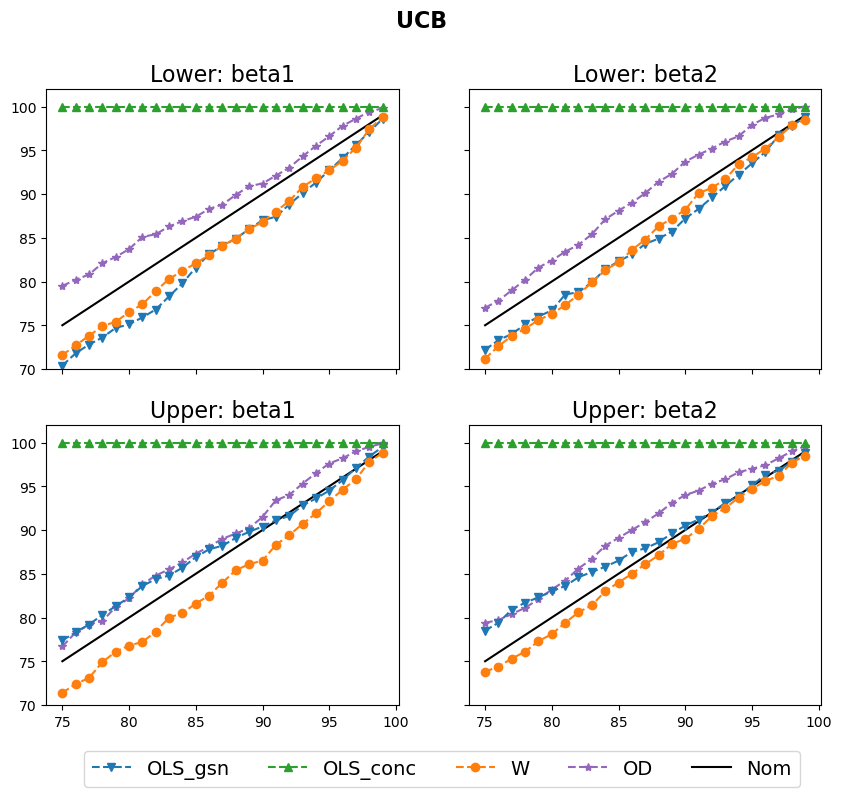

In [7]:
# Plotting 

path = 'figs/'
methods = ["OLS_gsn","OLS_conc", "W"]
markers = {}
markers['OLS_gsn'] = 'v'
markers['OLS_conc'] = '^'
markers['W'] = 'o'
markers['OD'] = '*'


colors = {}
colors['OLS_gsn'] = sns.color_palette()[0]
colors['OLS_conc'] = sns.color_palette()[2]
colors['W'] = sns.color_palette()[1]
colors['Nominal'] = (0, 0, 0)
colors['OLS_emp'] = sns.color_palette()[3]
colors['OD'] = sns.color_palette()[4]


legend_font_size = 14
label_font_size = 14
title_font_size = 16


#
# Display coverage results
#


methods = ['OLS_gsn', 'OLS_conc', 'W']
for p, policy in enumerate(policies):
    fig, axes = plt.subplots(2, K, figsize=(10, 8), sharey=True, sharex=True)
    for k in range(K):
        for m in range(len(methods)):
            method = methods[m]
            axes[0, k].errorbar(100*confidence_levels,
                               100*np.mean([lower_coverage[r][policy][method][k,:] for r in range(R)],axis=0),
                               label = method, 
                               marker=markers[method],
                               color=colors[method], 
                               linestyle='--')
            
        axes[0,k].plot(100*confidence_levels, 100*LeftCoverage[:, k, 0], color=colors['OD'], label='OD', marker=markers['OD'], linestyle = '--')   
        axes[0,k].plot(100*confidence_levels, 100*confidence_levels, color=colors['Nominal'], label='Nominal')
        axes[0, k].set_title("Lower: beta"+str(k+1), fontsize = title_font_size)
        axes[0, k].set_ylim([70, 102])
        
        
        for method in methods:

            axes[1, k].errorbar(100*confidence_levels,
                               100*np.mean([upper_coverage[r][policy][method][k,:] for r in range(R)],axis=0),
                               label = method,
                               marker = markers[method],
                               color=colors[method], 
                               linestyle = '--')
            
        axes[1,k].plot(100*confidence_levels, 100*RightCoverage[:, k, 0], color=colors['OD'], label='OD', marker=markers['OD'], linestyle = '--')   
        axes[1,k].plot(100*confidence_levels, 100*confidence_levels, color=colors['Nominal'], label='Nominal')
        axes[1,k].set_title("Upper: beta"+str(k+1), fontsize = title_font_size)
#     # fig.tight_layout()

    
    plt.figlegend( axes[1,0].get_lines(), methods+['OD'] + ['Nom'], 
                  loc = (0.1, 0.01), ncol=6, 
                  labelspacing=0. , 
                  fontsize = legend_font_size)
    fig.suptitle(policy, fontsize = title_font_size, fontweight='bold')
#     fig.savefig(path+'mab_{}_coverage'.format(policy))
    plt.show()




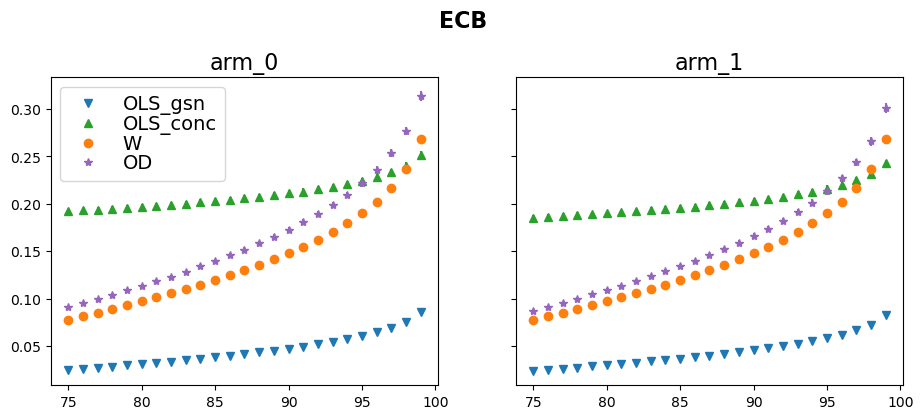

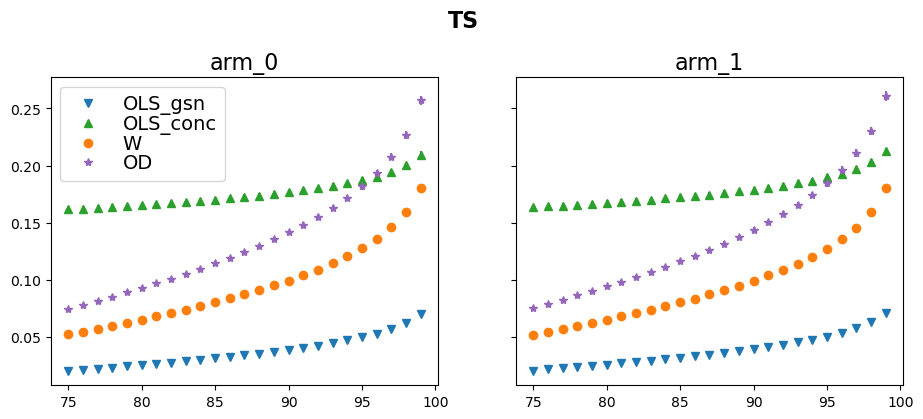

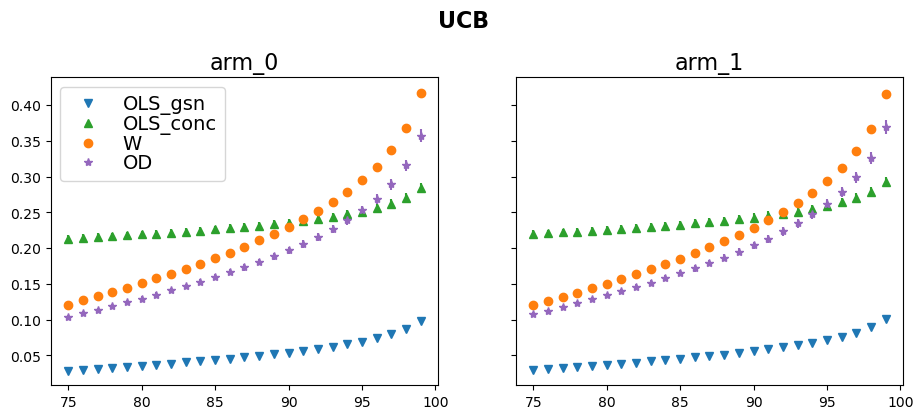

In [8]:
#
# Display width results
#
# For each policy and method, display mean width as a function of confidence level

gamman = 1 / (np.log(n) * np.log(np.log(n)))


policies = ["ECB", "TS", 'UCB']
methods = ['OLS_gsn', 'OLS_conc', 'W']
for policy in policies:
    fig, axes = plt.subplots(1, K, sharey=True)
    for k in range(K):
        
        for method in methods:
            axes[k].errorbar(100*confidence_levels, \
                    np.mean([thresholds_os[r][policy][method][k,:] for r in range(R)],axis=0), \
                    np.std([thresholds_os[r][policy][method][k,:] for r in range(R)], axis=0)/np.sqrt(R),\
                    label = method,
                    marker = markers[method],
                    color=colors[method],
                    linestyle='')
    
    # adding CI-width of online-debias: note od-CI length = sqrt{1/gamman} * ols_gsn_CI. 
        axes[k].errorbar(100*confidence_levels, \
        np.mean([np.sqrt(1.0 / gamman) * thresholds_os[r][policy]['OLS_gsn'][k,:] for r in range(R)],axis=0), \
        np.std([np.sqrt(1.0 / gamman) * thresholds_os[r][policy]['OLS_gsn'][k,:] for r in range(R)], axis=0)/np.sqrt(R),\
        label = 'od',
        marker = '*',
        color=sns.color_palette()[4],
        linestyle='')

            
        # axes[k].legend(loc='')
        axes[k].set_title('arm_{}'.format(k), fontsize = title_font_size)
        # axes[k].set_yscale('log', nonposy='clip')
    fig.suptitle(policy, fontsize = title_font_size, x=0.5, y=1.05, fontweight='bold')
#     plt.figlegend( axes[0].get_lines(), methods, 
#                   loc=(0.85, 0.5),
#                   ncol = 1,
#                   # loc= (0.75, 0.3),
#                   labelspacing=0. , 
#                   fontsize = legend_font_size)
    axes[0].legend( axes[0].get_lines(), 
                   methods + ['OD'], 
                  loc = 'upper left', 
                   ncol=1, 
                  labelspacing=0. ,
                   bbox_to_anchor=(0, 1),
                  fontsize = legend_font_size)
    fig.set_size_inches(11, 4, forward=True)
#    fig.savefig(path+'mab_{}_width'.format(policy), bbox_inches='tight', pad_inches=0.1)
    plt.show()



# Creating figure 2 from the paper 

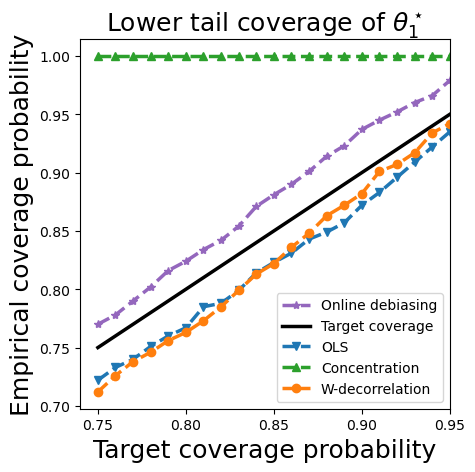

In [9]:

methodLabels = ["OLS", "Concentration", "W-decorrelation"]
from matplotlib.ticker import FormatStrFormatter

for m, method in enumerate(methods):
    plt.errorbar(confidence_levels,
                               np.mean([lower_coverage[r][policy][method][k,:] for r in range(R)],axis=0),
                               label = methodLabels[m], 
                               marker=markers[method],
                               color=colors[method], 
                               linestyle='--', linewidth = 2.5)
plt.plot(confidence_levels, LeftCoverage[:, k, 0], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(confidence_levels, confidence_levels, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Lower tail coverage of $\\theta_1^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_UCB_padding_lower.pdf", format="pdf", bbox_inches="tight")




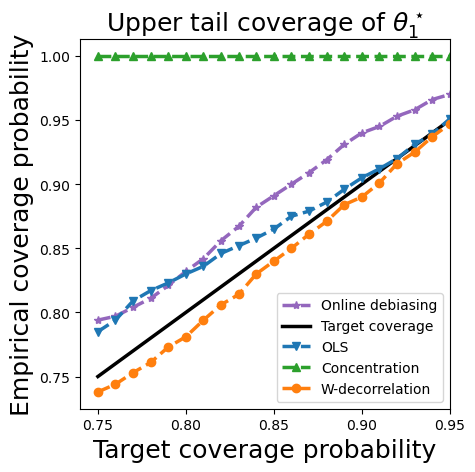

In [10]:
methodLabels = ["OLS", "Concentration", "W-decorrelation"]


for m, method in enumerate(methods):
    plt.errorbar(confidence_levels,
                               np.mean([upper_coverage[r][policy][method][k,:] for r in range(R)],axis=0),
                               label = methodLabels[m], 
                               marker=markers[method],
                               color=colors[method], 
                               linestyle='--', linewidth = 2.5)
plt.plot(confidence_levels, RightCoverage[:, k, 0], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(confidence_levels, confidence_levels, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Upper tail coverage of $\\theta_1^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability', fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_box_aspect(1)

plt.savefig("Plots/Fig_UCB_padding_upper.pdf", format="pdf", bbox_inches="tight")




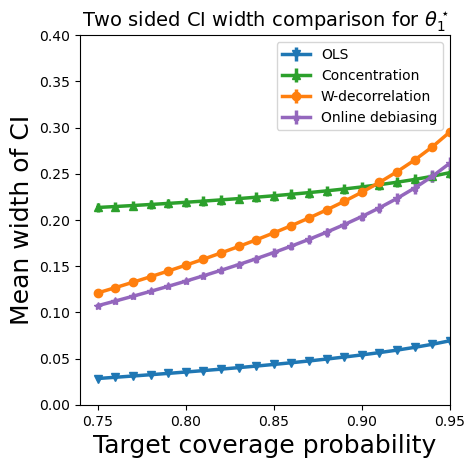

In [17]:
gamman = 1 / (np.log(n) * np.log(np.log(n)))

fig = plt.figure()
ax = fig.add_subplot()



for m, method in enumerate(methods):
    plt.errorbar(confidence_levels, \
            np.mean([thresholds_os[r][policy][method][0,:] for r in range(R)],axis=0), \
            np.std([thresholds_os[r][policy][method][0,:] for r in range(R)], axis=0)/np.sqrt(R),\
            label = methodLabels[m],
            marker = markers[method],
            color=colors[method],
            linestyle='-', linewidth = 2.5)
    
plt.errorbar(confidence_levels, \
        np.mean([np.sqrt(1.0 / gamman) * thresholds_os[r][policy]['OLS_gsn'][k,:] for r in range(R)],axis=0), \
        np.std([np.sqrt(1.0 / gamman) * thresholds_os[r][policy]['OLS_gsn'][k,:] for r in range(R)], axis=0)/np.sqrt(R),\
        label = 'Online debiasing',
        marker = '*',
        color=sns.color_palette()[4],
        linestyle='-',
            linewidth = 2.5)


plt.xlim([0.74, 0.95])
plt.ylim([0.0, 0.4])
plt.legend()

plt.title('Two sided CI width comparison for $\\theta_1^\\star$', fontsize = 14)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Mean width of CI', fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_box_aspect(1)

plt.savefig("Plots/Fig_UCB_padding_CI_width.pdf", format="pdf", bbox_inches="tight")


# plots for arm 2

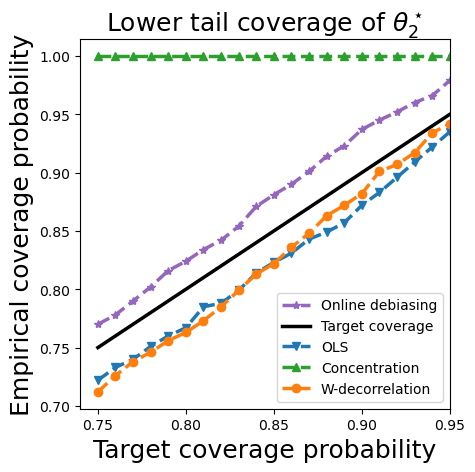

In [12]:
k = 1
methodLabels = ["OLS", "Concentration", "W-decorrelation"]
from matplotlib.ticker import FormatStrFormatter

for m, method in enumerate(methods):
    plt.errorbar(confidence_levels,
                               np.mean([lower_coverage[r][policy][method][k,:] for r in range(R)],axis=0),
                               label = methodLabels[m], 
                               marker=markers[method],
                               color=colors[method], 
                               linestyle='--', linewidth = 2.5)
plt.plot(confidence_levels, LeftCoverage[:, k, 0], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(confidence_levels, confidence_levels, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Lower tail coverage of $\\theta_2^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_UCB_padding_theta_2_lower.pdf", format="pdf", bbox_inches="tight")




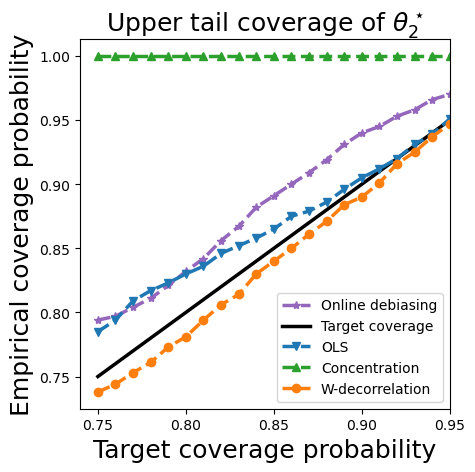

In [13]:
methodLabels = ["OLS", "Concentration", "W-decorrelation"]


for m, method in enumerate(methods):
    plt.errorbar(confidence_levels,
                               np.mean([upper_coverage[r][policy][method][k,:] for r in range(R)],axis=0),
                               label = methodLabels[m], 
                               marker=markers[method],
                               color=colors[method], 
                               linestyle='--', linewidth = 2.5)
plt.plot(confidence_levels, RightCoverage[:, k, 0], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(confidence_levels, confidence_levels, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Upper tail coverage of $\\theta_2^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability', fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_box_aspect(1)

plt.savefig("Plots/Fig_UCB_padding_theta_2_upper.pdf", format="pdf", bbox_inches="tight")




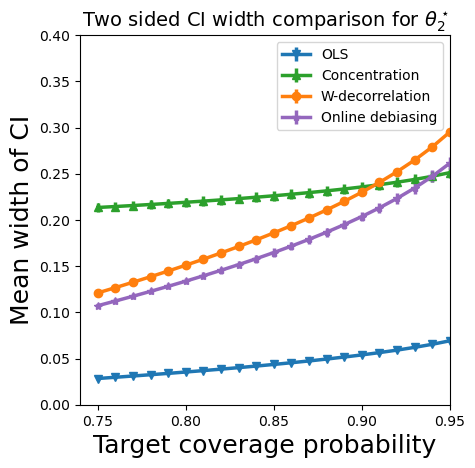

In [18]:
gamman = 1 / (np.log(n) * np.log(np.log(n)))

fig = plt.figure()
ax = fig.add_subplot()



for m, method in enumerate(methods):
    plt.errorbar(confidence_levels, \
            np.mean([thresholds_os[r][policy][method][0,:] for r in range(R)],axis=0), \
            np.std([thresholds_os[r][policy][method][0,:] for r in range(R)], axis=0)/np.sqrt(R),\
            label = methodLabels[m],
            marker = markers[method],
            color=colors[method],
            linestyle='-', linewidth = 2.5)
    
plt.errorbar(confidence_levels, \
        np.mean([np.sqrt(1.0 / gamman) * thresholds_os[r][policy]['OLS_gsn'][k,:] for r in range(R)],axis=0), \
        np.std([np.sqrt(1.0 / gamman) * thresholds_os[r][policy]['OLS_gsn'][k,:] for r in range(R)], axis=0)/np.sqrt(R),\
        label = 'Online debiasing',
        marker = '*',
        color=sns.color_palette()[4],
        linestyle='-',
            linewidth = 2.5)


plt.xlim([0.74, 0.95])
plt.ylim([0.0, 0.4])
plt.legend()

plt.title('Two sided CI width comparison for $\\theta_2^\\star$', fontsize = 14)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Mean width of CI', fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_box_aspect(1)

plt.savefig("Plots/Fig_UCB_padding_CI_theta_2_width.pdf", format="pdf", bbox_inches="tight")


In [19]:
import dill
dill.dump_session('notebook_bandit_1000_1000_UCB_padding.db')